# Installs & Imports

In [1]:
# Colab-specific installation for RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git > /dev/null 2>&1
!python rapidsai-csp-utils/colab/pip-install.py > /dev/null 2>&1

In [2]:
import cudf

# Test installation: Create a cuDF DataFrame and print it
gdf = cudf.DataFrame({"a":[1, 2, 3], "b":[4, 5, 6]})
display(gdf)

,a,b
0,1,4
1,2,5
2,3,6


In [3]:
!pip install -q jax jaxlib optax flax

In [4]:
import jax.numpy as jnp
import jax
from jax import random
from flax import linen as nn
import optax
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import cudf
import cuml
import cupy as cp
import numpy as np
import os
from flax.training import train_state, checkpoints
from typing import Any

# Load the Data

In [5]:
# Hyperparameters
N_LAGS = 12
FORECAST_HORIZON = 1
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 100
CHECKPOINT_PATH = '/content/checkpoints'

In [6]:
# Load Sunspot Dataset using RAPIDS cuDF
data = cudf.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv')

# Ensure the 'Month' column is in datetime format and set as the index
data['Month'] = cudf.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')

display(data)

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0
...,...
1983-08-01,71.8
1983-09-01,50.3
1983-10-01,55.8


# Prepare the Data

In [7]:
# Convert to numpy
data_numpy = data.to_pandas().values

# Preprocessing with MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_numpy.reshape(-1, 1)).flatten()

In [8]:
# Function to generate lagged data
def create_lagged_data(data, n_lags, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - n_lags - forecast_horizon + 1):
        X.append(data[i:i + n_lags].reshape(-1, 1))  # Lagged data
        y.append(data[i + n_lags:i + n_lags + forecast_horizon])  # Forecasted value(s)
    return np.array(X), np.array(y)

# Generate lagged data from the entire dataset
X, y = create_lagged_data(data_scaled, N_LAGS, FORECAST_HORIZON)

In [9]:
# Dynamically calculate the sizes for the train, validation, and test splits
total_samples = len(X)
train_size = int(0.7 * total_samples)  # 70% for training
val_size = int(0.15 * total_samples)   # 15% for validation
test_size = total_samples - train_size - val_size  # Remaining for test

print(f"Total samples: {total_samples}")
print(f"Train samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

# Train/Validation/Test split based on calculated sizes
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

Total samples: 2808
Train samples: 1965
Validation samples: 421
Test samples: 422


In [10]:
# Dataset for Time Series Forecasting
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = np.asarray(X)
        self.y = np.asarray(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return jnp.array(self.X[idx]), jnp.array(self.y[idx])

In [11]:
# Create Datasets with complete lagged data
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [12]:
# Custom collate function for JAX
def jax_numpy_collate(batch):
    """Collate function for JAX that converts batches to NumPy arrays."""
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [jax_numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

In [13]:
# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=jax_numpy_collate)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=jax_numpy_collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=jax_numpy_collate)

print(f"Train loader length: {len(train_loader)}")
print(f"Validation loader length: {len(val_loader)}")
print(f"Test loader length: {len(test_loader)}")

Train loader length: 62
Validation loader length: 14
Test loader length: 14


# Define the Model

In [14]:
# 1D ResNet Block for Time Series
class ResNetBlock1D(nn.Module):
    act_fn: callable
    c_out: int
    subsample: bool = False

    @nn.compact
    def __call__(self, x, train=True):
        z = nn.Conv(self.c_out, kernel_size=(3,), strides=(1,) if not self.subsample else (2,), kernel_init=nn.initializers.he_normal(), use_bias=False)(x)
        z = nn.BatchNorm(use_running_average=not train)(z)
        z = self.act_fn(z)
        z = nn.Conv(self.c_out, kernel_size=(3,), kernel_init=nn.initializers.he_normal(), use_bias=False)(z)
        z = nn.BatchNorm(use_running_average=not train)(z)

        if self.subsample:
            x = nn.Conv(self.c_out, kernel_size=(1,), strides=(2,), kernel_init=nn.initializers.he_normal())(x)

        return self.act_fn(z + x)

In [15]:
# 1D ResNet for Time Series Forecasting
class ResNet1D(nn.Module):
    forecast_horizon: int
    act_fn: callable
    block_class: nn.Module = ResNetBlock1D
    num_blocks: tuple = (3, 3, 3)
    c_hidden: tuple = (64, 128, 256)

    @nn.compact
    def __call__(self, x, train=True):
        x = nn.Conv(self.c_hidden[0], kernel_size=(3,), kernel_init=nn.initializers.he_normal(), use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = self.act_fn(x)

        for block_idx, block_count in enumerate(self.num_blocks):
            for bc in range(block_count):
                subsample = (bc == 0 and block_idx > 0)
                x = self.block_class(c_out=self.c_hidden[block_idx], act_fn=self.act_fn, subsample=subsample)(x, train=train)

        x = x.mean(axis=1)  # Global average pooling over the time dimension
        x = nn.Dense(self.forecast_horizon)(x)
        return x

# Train the Model

In [16]:
# TrainState extended to include batch statistics
class TrainState(train_state.TrainState):
    batch_stats: Any

# TrainerModule class
class TrainerModule:
    def __init__(self, model_class, model_hparams, optimizer_name, optimizer_hparams, seed=42):
        """
        Module for summarizing all training functionalities for time series forecasting.
        """
        self.model_class = model_class
        self.model_hparams = model_hparams
        self.optimizer_name = optimizer_name
        self.optimizer_hparams = optimizer_hparams
        self.seed = seed
        # Create empty model, no parameters yet
        self.model = self.model_class(**self.model_hparams)
        # Create jitted training and eval functions
        self.create_functions()

    def create_functions(self):
        # Loss calculation for regression (MSE)
        def calculate_loss(params, batch_stats, batch, train):
            x, y = batch
            outs = self.model.apply({'params': params, 'batch_stats': batch_stats},
                                    x, train=train,
                                    mutable=['batch_stats'] if train else False)
            logits, new_model_state = outs if train else (outs, None)
            loss = jnp.mean((logits.flatten() - y.flatten()) ** 2)  # MSE for time series forecasting
            return loss, (new_model_state if train else None)

        # Training step
        def train_step(state, batch):
            loss_fn = lambda params: calculate_loss(params, state.batch_stats, batch, train=True)
            ret, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            loss, new_model_state = ret[0], ret[1]
            state = state.apply_gradients(grads=grads, batch_stats=new_model_state['batch_stats'])
            return state, loss

        # Evaluation step
        def eval_step(state, batch):
            loss, _ = calculate_loss(state.params, state.batch_stats, batch, train=False)
            return loss

        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_batch):
        init_rng = jax.random.PRNGKey(self.seed)
        variables = self.model.init(init_rng, exmp_batch, train=True)
        self.init_params, self.init_batch_stats = variables['params'], variables['batch_stats']
        self.state = None

    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        if self.optimizer_name.lower() == 'adam':
            opt_class = optax.adam
        elif self.optimizer_name.lower() == 'adamw':
            opt_class = optax.adamw
        elif self.optimizer_name.lower() == 'sgd':
            opt_class = optax.sgd
        else:
            raise ValueError(f'Unknown optimizer "{self.optimizer_name}"')

        lr_schedule = optax.piecewise_constant_schedule(
            init_value=self.optimizer_hparams.pop('lr'),
            boundaries_and_scales={
                int(num_steps_per_epoch * num_epochs * 0.6): 0.1,
                int(num_steps_per_epoch * num_epochs * 0.85): 0.1
            }
        )

        optimizer = optax.chain(
            optax.clip(1.0),
            opt_class(lr_schedule, **self.optimizer_hparams)
        )

        self.state = TrainState.create(apply_fn=self.model.apply,
                                       params=self.init_params,
                                       batch_stats=self.init_batch_stats,
                                       tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=200):
        self.init_optimizer(num_epochs, len(train_loader))
        best_val_loss = float('inf')  # Initialize best validation loss to a large value

        for epoch_idx in range(1, num_epochs + 1):
            self.train_epoch(train_loader, epoch_idx)
            val_loss = self.eval_model(val_loader)
            print(f"Epoch {epoch_idx}, Validation Loss: {val_loss}\n")

            # Check if the current validation loss is better than the best so far
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.save_model(step=epoch_idx, best=True)  # Save the best model
                print(f"Best model updated at epoch {epoch_idx} with Validation Loss: {val_loss}")

        print(f"Training complete. Best validation loss: {best_val_loss}")

    def train_epoch(self, train_loader, epoch):
        for batch in train_loader:
            self.state, loss = self.train_step(self.state, batch)
            print(f"Epoch {epoch}, Loss: {loss}")

    def eval_model(self, data_loader):
        total_loss = 0.0
        count = 0
        for batch in data_loader:
            loss = self.eval_step(self.state, batch)
            total_loss += loss
            count += 1

        # Safeguard against division by zero
        if count == 0:
            raise ValueError("No batches processed in eval_model. Ensure that the test_loader contains data.")

        return total_loss / count

    def save_model(self, step=0, best=False):
        # Ensure the checkpoint directory exists
        os.makedirs(CHECKPOINT_PATH, exist_ok=True)

        # Save the best model or checkpoint
        if best:
            checkpoint_name = "best_model.ckpt"
        else:
            checkpoint_name = f"checkpoint_{step}"

        checkpoint_path = os.path.join(CHECKPOINT_PATH, checkpoint_name)

        checkpoints.save_checkpoint(
            ckpt_dir=checkpoint_path,
            target={'params': self.state.params, 'batch_stats': self.state.batch_stats},
            step=step,
            overwrite=True
        )
        print(f"Model saved at epoch {step} to {checkpoint_path}\n")

    def load_best_model(self):
        best_model_path = os.path.join(CHECKPOINT_PATH, "best_model.ckpt")

        print(f"Loading best model from {best_model_path}...")

        state_dict = checkpoints.restore_checkpoint(ckpt_dir=best_model_path, target=None)

        if state_dict is None:
            raise ValueError(f"No best model checkpoint found at {best_model_path}")

        print("Best model loaded successfully.")

        self.state = TrainState.create(
            apply_fn=self.model.apply,
            params=state_dict['params'],
            batch_stats=state_dict['batch_stats'],
            tx=self.state.tx if self.state else optax.sgd(0.1)
        )

    def checkpoint_exists(self, pretrained=False):
        if pretrained:
            # Check for the pretrained model checkpoint
            checkpoint_path = os.path.join(CHECKPOINT_PATH, "pretrained_model.ckpt")
        else:
            # Check for the regular training checkpoint
            checkpoint_path = os.path.join(CHECKPOINT_PATH, "model.ckpt")

        return os.path.isfile(checkpoint_path)

In [17]:
# Initialize the TrainerModule
model_hparams = {
    "forecast_horizon": FORECAST_HORIZON,  # Number of future steps to predict
    "act_fn": nn.relu,
    "block_class": ResNetBlock1D,  # The block class for ResNet
    "num_blocks": (3, 3, 3),  # Number of blocks in each stage
    "c_hidden": (64, 128, 256)  # Number of channels in each block
}

# Initialize the TrainerModule
trainer = TrainerModule(
    model_class=ResNet1D,
    model_hparams=model_hparams,
    optimizer_name='adam',
    optimizer_hparams={'lr': LEARNING_RATE},
    seed=42
)

# Initialize the model with a sample batch
exmp_batch = jnp.ones((BATCH_SIZE, N_LAGS, 1))  # Shape: (batch_size, n_lags, features)
trainer.init_model(exmp_batch)

# Start training
trainer.train_model(train_loader, val_loader, num_epochs=EPOCHS)

Epoch 1, Loss: 1.1711078882217407
Epoch 1, Loss: 12.506063461303711
Epoch 1, Loss: 2.782212018966675
Epoch 1, Loss: 1.5214879512786865
Epoch 1, Loss: 1.345574140548706
Epoch 1, Loss: 3.0038015842437744
Epoch 1, Loss: 2.076833724975586
Epoch 1, Loss: 1.7478201389312744
Epoch 1, Loss: 1.0699297189712524
Epoch 1, Loss: 1.4638140201568604
Epoch 1, Loss: 1.1067070960998535
Epoch 1, Loss: 1.5249247550964355
Epoch 1, Loss: 0.41585293412208557
Epoch 1, Loss: 2.3837790489196777
Epoch 1, Loss: 0.2865419089794159
Epoch 1, Loss: 0.4591810405254364
Epoch 1, Loss: 0.44027984142303467
Epoch 1, Loss: 0.7488676905632019
Epoch 1, Loss: 0.49806517362594604
Epoch 1, Loss: 0.8021149635314941
Epoch 1, Loss: 1.3515088558197021
Epoch 1, Loss: 0.48664525151252747
Epoch 1, Loss: 0.4601151943206787
Epoch 1, Loss: 0.19567832350730896
Epoch 1, Loss: 0.2503708302974701
Epoch 1, Loss: 0.565105676651001
Epoch 1, Loss: 0.6396175622940063
Epoch 1, Loss: 0.916602373123169
Epoch 1, Loss: 0.3006014823913574
Epoch 1, Loss:

Streaming output truncated to the last 5000 lines.

Epoch 23, Loss: 0.005849855020642281
Epoch 23, Loss: 0.023043427616357803
Epoch 23, Loss: 0.026278488337993622
Epoch 23, Loss: 0.04270545765757561
Epoch 23, Loss: 0.03259565308690071
Epoch 23, Loss: 0.05083120986819267
Epoch 23, Loss: 0.014585806056857109
Epoch 23, Loss: 0.008842313662171364
Epoch 23, Loss: 0.005339513532817364
Epoch 23, Loss: 0.005469717551022768
Epoch 23, Loss: 0.04533325508236885
Epoch 23, Loss: 0.03925547003746033
Epoch 23, Loss: 0.010750910267233849
Epoch 23, Loss: 0.03388750180602074
Epoch 23, Loss: 0.08673188090324402
Epoch 23, Loss: 0.017740046605467796
Epoch 23, Loss: 0.008831914514303207
Epoch 23, Loss: 0.004472514148801565
Epoch 23, Loss: 0.0030970736406743526
Epoch 23, Loss: 0.014069498516619205
Epoch 23, Loss: 0.029346730560064316
Epoch 23, Loss: 0.03675214946269989
Epoch 23, Loss: 0.016968846321105957
Epoch 23, Loss: 0.0312834233045578
Epoch 23, Loss: 0.044512901455163956
Epoch 23, Loss: 0.05590347945690

# Evaluate the Model

In [18]:
# Check test dataloader
for batch in test_loader:
    x, y = batch
    print(f"Test batch input shape: {x.shape}, Test batch output shape: {y.shape}")

Test batch input shape: (32, 12, 1), Test batch output shape: (32, 1)
Test batch input shape: (32, 12, 1), Test batch output shape: (32, 1)
Test batch input shape: (32, 12, 1), Test batch output shape: (32, 1)
Test batch input shape: (32, 12, 1), Test batch output shape: (32, 1)
Test batch input shape: (32, 12, 1), Test batch output shape: (32, 1)
Test batch input shape: (32, 12, 1), Test batch output shape: (32, 1)
Test batch input shape: (32, 12, 1), Test batch output shape: (32, 1)
Test batch input shape: (32, 12, 1), Test batch output shape: (32, 1)
Test batch input shape: (32, 12, 1), Test batch output shape: (32, 1)
Test batch input shape: (32, 12, 1), Test batch output shape: (32, 1)
Test batch input shape: (32, 12, 1), Test batch output shape: (32, 1)
Test batch input shape: (32, 12, 1), Test batch output shape: (32, 1)
Test batch input shape: (32, 12, 1), Test batch output shape: (32, 1)
Test batch input shape: (6, 12, 1), Test batch output shape: (6, 1)


In [19]:
# Load the best model
trainer.load_best_model()

# Evaluate on test data
test_loss = trainer.eval_model(test_loader)
print(f"\nTest Loss (MSE): {test_loss}")

Loading best model from /content/checkpoints/best_model.ckpt...
Best model loaded successfully.


/usr/local/lib/python3.10/dist-packages/orbax/checkpoint/type_handlers.py:1552: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(



Test Loss (MSE): 0.03368891403079033


In [20]:
# Prediction function
def predict(trainer, data_loader):
    preds = []
    for batch in data_loader:
        x, _ = batch  # Extract features (x) only, ignoring labels (y)
        # Generate prediction using the model
        pred = trainer.state.apply_fn({'params': trainer.state.params, 'batch_stats': trainer.state.batch_stats}, x, train=False)
        preds.append(pred)
    preds = jnp.concatenate(preds, axis=0)  # Concatenate predictions
    return preds

In [21]:
# Make predictions on the test data
predictions = predict(trainer, test_loader)

# Inverse transform the predictions to the original scale
preds_final = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

In [22]:
# Extract the actual test values from the test loader
actuals = []
for batch in test_loader:
    _, y = batch  # Extract the target labels only
    actuals.append(y)
actuals = jnp.concatenate(actuals, axis=0)
actuals_final = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()

In [23]:
# Convert NumPy arrays to cuPy arrays
actuals_cp = cp.array(actuals_final)
preds_cp = cp.array(preds_final)

In [24]:
# Compute MSE
mse = cuml.metrics.mean_squared_error(actuals_cp, preds_cp)

# Compute MAE
mae = cuml.metrics.mean_absolute_error(actuals_cp, preds_cp)

# Compute MAPE
def mean_absolute_percentage_error_cuml(y_true, y_pred):
    # Add a small epsilon to avoid division by zero
    epsilon = 1e-10
    return cp.mean(cp.abs((y_true - y_pred) / (y_true + epsilon))) * 100

mape = mean_absolute_percentage_error_cuml(actuals_cp, preds_cp)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Mean Squared Error (MSE): 2252.783203125
Mean Absolute Error (MAE): 33.420982360839844
Mean Absolute Percentage Error (MAPE): 204.48916625976562


In [25]:
# Create a cuDF DataFrame to store the metrics
metrics_df = cudf.DataFrame({
    'Metric': ['MSE', 'MAE', 'MAPE'],
    'Value': [mse.item(), mae.item(), mape.item()]  # Convert cuPy values to standard Python floats
})

# Display the cuDF DataFrame
display(metrics_df)

,Metric,Value
0,MSE,2252.783203
1,MAE,33.420982
2,MAPE,204.489166


# Plot the Results

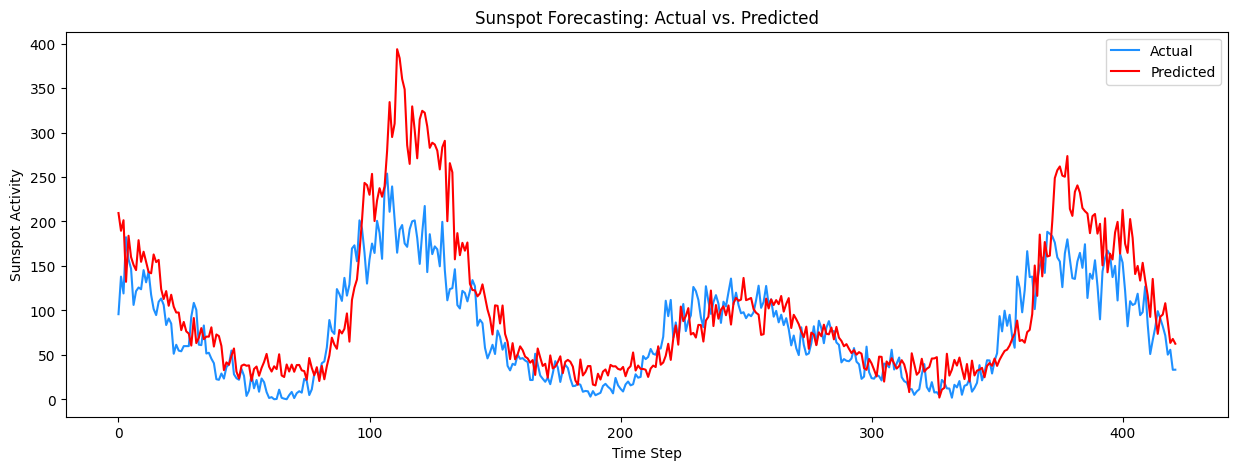

In [26]:
# Plot the actual vs. predicted values
plt.figure(figsize=(15, 5))
plt.plot(actuals_final, label='Actual', color='dodgerblue')
plt.plot(preds_final, label='Predicted', color='red')
plt.title('Sunspot Forecasting: Actual vs. Predicted')
plt.xlabel('Time Step')
plt.ylabel('Sunspot Activity')
plt.legend()
plt.show()

In [27]:
# Retrieve the original time index for the data
original_dates = data.index

# Extract the corresponding dates for the test split
test_dates = original_dates[train_size + val_size:]

print(f"Shape of test_dates: {test_dates.shape}")
print(f"Shape of actuals_final: {actuals_final.shape}")
print(f"Shape of preds_final: {preds_final.shape}")

Shape of test_dates: (434,)
Shape of actuals_final: (422,)
Shape of preds_final: (422,)


In [28]:
# Get the smallest length
min_length = min(len(test_dates), len(actuals_final), len(preds_final))

# Trim arrays to match the smallest length
test_dates = test_dates[:min_length]
actuals_final = actuals_final[:min_length]
preds_final = preds_final[:min_length]

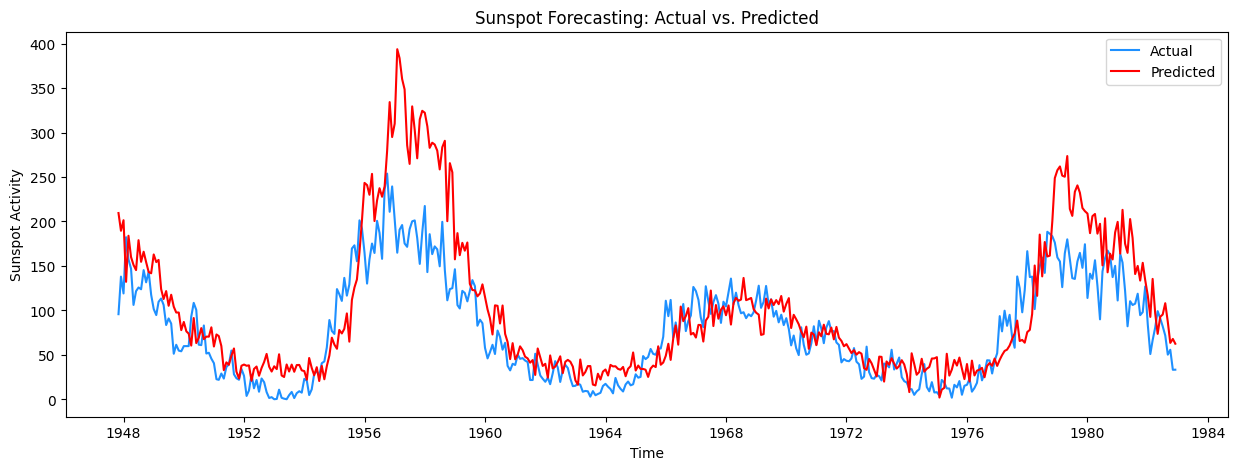

In [29]:
# Plot the actual vs. predicted values with proper indices
plt.figure(figsize=(15, 5))
plt.plot(test_dates.to_pandas(), actuals_final, label='Actual', color='dodgerblue')
plt.plot(test_dates.to_pandas(), preds_final, label='Predicted', color='red')
plt.title('Sunspot Forecasting: Actual vs. Predicted')
plt.xlabel('Time')
plt.ylabel('Sunspot Activity')
plt.legend()
plt.show()